202007D nociliates bloom timing

In [2]:
import datetime as dt
from erddapy import ERDDAP
import glob
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import pandas as pd
from pathlib import Path
import xarray as xr

from salishsea_tools import places

%matplotlib inline

## Model Results

In [3]:
drop_vars = [
    "time_centered",
    "time_centered_bounds",
    "time_counter_bounds",
    "nav_lat",
    "bounds_lat",
    "nav_lon",
    "bounds_lon",
    "area",
    "deptht_bounds",
]
chunks = {
    "time_counter": 1,
    "deptht": 1,
}

In [4]:
def prep_timeseries(dir_path, file_pattern, n_days): 
    ds_files = sorted(dir_path.glob(file_pattern))
    ds = xr.open_mfdataset(
        ds_files[:n_days],
        chunks=chunks,
        drop_variables=drop_vars,
    )
    S3y, S3x = places.PLACES['S3']['NEMO grid ji'][0], places.PLACES['S3']['NEMO grid ji'][1]
    fourkm = 8
    timeseries = ds.isel(deptht = 1, y = slice(S3y-fourkm, S3y+fourkm+1), 
                             x =  slice(S3x-fourkm, S3x+fourkm+1))
    
    return timeseries

In [5]:
directory = '202007D-nociliates'
dir_path = Path(f"/data/sallen/results/MEOPAR/202007/{directory}")
year = 2015
months_regex = '0[23]'
file_pattern = f"SalishSea_1d_{year}{months_regex}*ptrc_T*.nc"
timeseries2015 = prep_timeseries(dir_path, file_pattern, -1)

In [6]:
timeseries2015.load(scheduler='processes', num_workers=4);

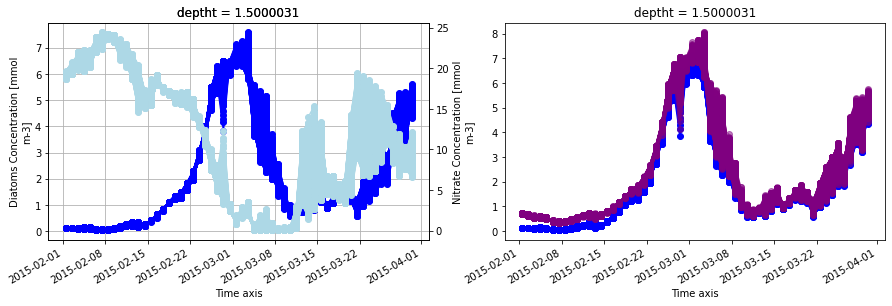

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
for i in range(timeseries2015.x.shape[0]):
    for j in range(timeseries2015.y.shape[0]):
        timeseries2015.diatoms[:, j, i].plot(ax=axs[0], color='blue', marker='o')
        timeseries2015.diatoms[:, j, i].plot(ax=axs[1], color='blue', marker='o')
ax2 = axs[0].twinx()
for i in range(timeseries2015.x.shape[0]):
    for j in range(timeseries2015.y.shape[0]):
        timeseries2015.nitrate[:, j, i].plot(ax=ax2, color='lightblue', marker='o')
axs[0].grid()
for i in range(timeseries2015.x.shape[0]):
    for j in range(timeseries2015.y.shape[0]):
        (timeseries2015.diatoms+timeseries2015.flagellates+timeseries2015.ciliates)[:, j, i].plot(ax=axs[1], color='purple', marker='o', alpha=0.5);

## Observations

In [30]:
server = "https://salishsea.eos.ubc.ca/erddap"

protocol = "tabledap"

dataset_id = "ubcONCTWDP1mV18-01"

response = "nc"

variables = [
    "latitude",
    "longitude",
    "chlorophyll",
    "time",
]

fourkmlat = 4/110.574
fourkmlon = 4/(111.320*np.cos(50*np.pi/180.))
lon, lat = places.PLACES['S3']['lon lat']

constraints = {
    "time>=": "2015-02-01T00:00:00Z",
    "time<=": "2015-04-01T00:00:00Z",
    "latitude>=": lat - fourkmlat,
    "latitude<=": lat + fourkmlat,
    "longitude>=": lon - fourkmlon,
    "longitude<=": lon + fourkmlon,
}

print(constraints)

{'time>=': '2015-02-01T00:00:00Z', 'time<=': '2015-04-01T00:00:00Z', 'latitude>=': 49.08882513068171, 'latitude<=': 49.16117486931829, 'longitude>=': -123.61390096395475, 'longitude<=': -123.50209903604527}


In [24]:
obs = ERDDAP(server=server, protocol=protocol,)

obs.dataset_id = dataset_id
obs.variables = variables
obs.constraints = constraints

In [25]:
obs_pd = obs.to_pandas(index_col="time (UTC)", parse_dates=True,).dropna()

In [26]:
obs_pd.head()

,latitude (degrees_north),longitude (degrees_east),chlorophyll (ug/l)
time (UTC),,,
2015-03-07 16:45:00+00:00,49.128117,-123.507033,9.968383
2015-03-07 16:46:00+00:00,49.130533,-123.513517,9.544883
2015-03-07 16:47:00+00:00,49.133000,-123.520033,9.571100
2015-03-07 16:48:00+00:00,49.135417,-123.526583,9.843350
2015-03-07 16:49:00+00:00,49.137833,-123.533183,10.087367


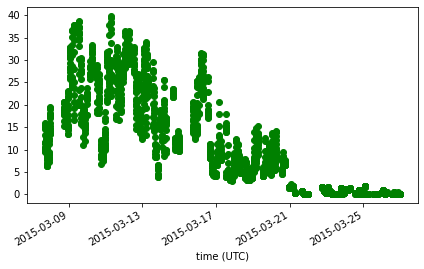

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
obs_pd['chlorophyll (ug/l)'].plot(ax=ax, marker='o', color='green', linewidth=0);

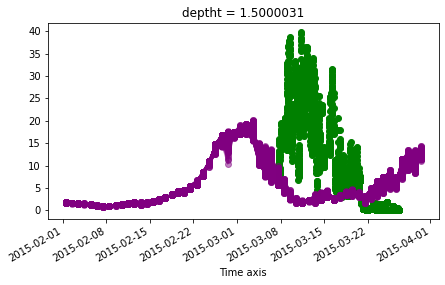

In [29]:
N2Chl = 2.5
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
obs_pd['chlorophyll (ug/l)'].plot(ax=ax, marker='o', color='green', linewidth=0);
for i in range(timeseries2015.x.shape[0]):
    for j in range(timeseries2015.y.shape[0]):
        ((timeseries2015.diatoms+timeseries2015.flagellates+timeseries2015.ciliates)[:, j, i]*N2Chl).plot(ax=ax, color='purple', marker='o', alpha=0.5);